# stacked LSTMs

LSTMs look for sequential data, in 3 dimensions: __samples__, __time steps__, & __features__, in that order.

however, with keras ```LSTM()``` default parameters, LSTMs output only a single value (after their multiple time steps).

to remedy this, we can set the ```return_sequences``` parameter to ```True```, and our LSTMs will output one value per time step--a 3D array __sequence__ we can feed into the next LSTM layer.

In [2]:
# imports

from keras.models import Sequential
from keras.layers import LSTM
from numpy import array

Using TensorFlow backend.


#### two-dimensional, single-value output

here's an example of an LSTM output of a single value, in the form of a 2D array:

In [25]:
# initialize model

default_lstm = Sequential()

# design model

default_lstm.add(LSTM(1, input_shape=(5, 1)))

# compile model

default_lstm.compile(optimizer='adam', loss='mse')


the ```default_lstm``` model above takes as input:

* 1 memory cell
* 5 time steps
* 1 feature

to calculate loss and minimize the error, ```default_lstm``` uses:

* __ mean squared erorr__ ('mse') *loss function*
* __adam__ gradient descent as its *optimizer*

let's generate some data:

In [28]:
# create data then reshape() into 3d array

data = array([0.1, 0.2, 0.3, 0.4, 0.5]).reshape((1, 5, 1))

get predictions:

In [29]:
preds = default_lstm.predict(data)

print(preds)

[[-0.13126174]]


this run of our ```default_lstm``` model produced the value -0.13126174, outputting it as a 2d array:

```[[-0.13126174]]```

*note: LSTMs are stochastic, so if i run this again, it may produce a different result...but that result will still be a single value in a 2d array.*

we need a __sequence__ of values, returned as a 3d array so that it can be fed into a hypothetical next LSTM layer.

now we'll set ```output_sequences=True``` to get one output for each time step, as an array that's ready for another LSTM layer:

In [30]:
seq_model = Sequential()

seq_model.add(LSTM(1, return_sequences=True, input_shape=(5, 1)))

seq_model.compile(optimizer='adam', loss='mse')

print(seq_model.predict(data))

[[[ 0.00361657]
  [ 0.00901196]
  [ 0.01538688]
  [ 0.02239283]
  [ 0.02988665]]]


sweet! our ```seq_model``` outputs a 3d array of values, one for each time step, i.e. one per each input value.

## damped sine wave problem

*(sine wave generation & plotting code from jason brownlee's excellent course on LSTMs at machinelearningmastery.com)*

a [damped sine wave](https://en.wikipedia.org/wiki/Damped_sine_wave "damped sine wave") is a sine wave whose amplitude is gradually decreasing (approaching zero).

we'd like to see whether an LSTM trained on an earlier part of the wave can predict the dampening.

after all, a sine wave is really just another sequence of values, right?

In [32]:
from math import sin
from math import pi
from matplotlib import pyplot
%matplotlib inline

here's what a regular sine wave looks like:

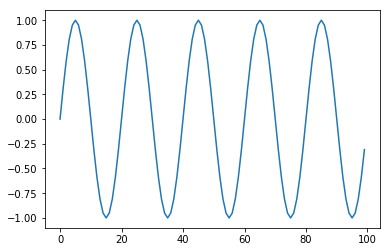

In [38]:
# create sine wave sequence

length = 100
freq = 5
seq = [sin(2 * pi * freq * (i/float(length))) for i in range(length)]

# plot sequence

pyplot.plot(seq)

here's a sine wave whose amplitude is gradually approaching zero--a __damped__ sine wave:

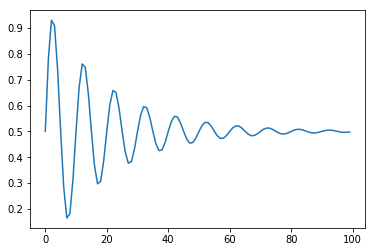

In [44]:
from math import exp

damped_length = 100
period = 10
decay = 0.05

# create sequence

damped_seq = [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i) 
              for i in range(length)]

# plot sequence

pyplot.plot(damped_seq)

### training data: random damped sine waves

using the script above, we can create a function to generate random damped sine wave sequences, which can then be used as training data.

#### where the randomness comes from

our sequences will be "random" (actually [pseudorandom](https://en.wikipedia.org/wiki/Pseudorandomness "pseudorandom")) through pseudorandomly selected period and decay. 

In [61]:
# generate a SINGLE damped sine wave sequence
# specifying length (time steps), period, & decay

import random

def make_sin_seq(time_steps, period, decay):
    return [0.5 + 0.5 * sin(2 * pi * i / period) * exp(-decay * i)
           for i in range(time_steps)]

# integrate make_sin_seq() in a new function
# to generate MANY sequences

def make_many_seq(n_early_steps, n_patterns, n_later_steps):
    
    '''
    creates damped (exponential decay)sine-shaped 
    sequences for modeling sequence prediction. 
    assigns matching pairs of early time steps and 
    later time steps to X and y respectively, to serve as
    training data and targets.
    '''
    
    # places to store sequence chunks
    
    X, y = list(), list()
    
    # iterator allows user to specify # of examples
    
    for _ in range(n_patterns):
        
        # drawing pseudorandom numbers from appropriate distributions
        
        period_rndm = random.randint(10, 20)
        
        decay_rndm = random.uniform(0.01, 0.1)
        
        rndm_seq = make_sin_seq(n_early_steps + n_later_steps, 
                                period_rndm, decay_rndm)
        
        # chop the sequence at the specified point
        # assign early time steps to X, later to y
        
        X.append(rndm_seq[:-n_later_steps])
        y.append(rndm_seq[-n_later_steps:])
    
    # shape output to 3d array for LSTM
    
    X = array(X).reshape(n_patterns, n_early_steps, 1)
    y= array(y).reshape(n_patterns, n_later_steps)
    
    # return prepared datasets
    
    return X, y
    

call the ```make_many_seq``` function and plot results:

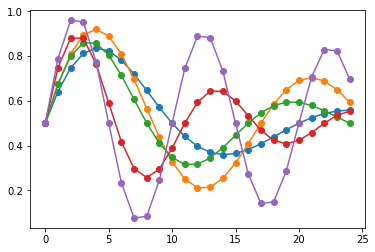

In [67]:
# call the function

X, y = make_many_seq(20, 5, 5)

# plot resulting random damped sine sequences

for i in range(len(X)):
    pyplot.plot([x for x in X[i, :, 0]] + 
               [x for x in y[i]], '-o')